# **TwiSTAR - Flat earth data**



##Librerías

In [ ]:
import os
import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt
import plotly.express as px
!pip install neattext
import neattext as ntx

import nltk.downloader
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.util import ngrams


##Lectura de datos

Para el presente análisis de texto, se usa un dataset extraído con Tweepy y relacionado a *menciones* sobre "*flat earth*" en Twitter.

In [ ]:
data = pd.read_csv('flat_earth_tweets.csv')

In [ ]:
data.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1472188544718450688,L Fnord Hubbard,New River Valley and Bermuda,fellow conspirator of the epoch,2017-12-07 07:45:07,64,23,3,False,2021-12-18 12:54:35,Ignore this message.\nP D Q Bach binds your fu...,['FlatEarth'],fnorder,0,0,False
1,1472182078347395075,Charles Putin,Wherever The Truth Is,Every Horizon is Flat for a reason.,2015-08-13 00:26:04,85,1,595,False,2021-12-18 12:28:53,History is a Lie \n#FlatEarth https://t.co/QFR...,['FlatEarth'],Twitter for Android,0,0,False
2,1472181355844976644,Charles Putin,Wherever The Truth Is,Every Horizon is Flat for a reason.,2015-08-13 00:26:04,85,1,595,False,2021-12-18 12:26:01,"Flat water. Sea Level is Key in proving What ""...",NaN,Twitter for Android,0,0,False
3,1472178963720163335,L Fnord Hubbard,New River Valley and Bermuda,fellow conspirator of the epoch,2017-12-07 07:45:07,64,23,3,False,2021-12-18 12:16:31,The surgeon general warns that a dead rock sta...,['flatEarth'],fnorder,0,0,False
4,1472178578376863745,Charles Putin,Wherever The Truth Is,Every Horizon is Flat for a reason.,2015-08-13 00:26:04,85,1,595,False,2021-12-18 12:14:59,The Water between Skegness and Hunstanton is F...,['FlatEarth'],Twitter for Android,0,0,False


In [ ]:
display(data.shape, str(data.shape[0])+" tweets in dataset") 

(752, 16)

'752 tweets in dataset'

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752 entries, 0 to 751
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                752 non-null    int64 
 1   user_name         752 non-null    object
 2   user_location     567 non-null    object
 3   user_description  699 non-null    object
 4   user_created      752 non-null    object
 5   user_followers    752 non-null    int64 
 6   user_friends      752 non-null    int64 
 7   user_favourites   752 non-null    int64 
 8   user_verified     752 non-null    bool  
 9   date              752 non-null    object
 10  text              752 non-null    object
 11  hashtags          510 non-null    object
 12  source            752 non-null    object
 13  retweets          752 non-null    int64 
 14  favorites         752 non-null    int64 
 15  is_retweet        752 non-null    bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 83.8+ KB


In [ ]:
data['date'] = pd.to_datetime(data['date']).dt.date  #converting date column to date format
data.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1472188544718450688,L Fnord Hubbard,New River Valley and Bermuda,fellow conspirator of the epoch,2017-12-07 07:45:07,64,23,3,False,2021-12-18,Ignore this message.\nP D Q Bach binds your fu...,['FlatEarth'],fnorder,0,0,False
1,1472182078347395075,Charles Putin,Wherever The Truth Is,Every Horizon is Flat for a reason.,2015-08-13 00:26:04,85,1,595,False,2021-12-18,History is a Lie \n#FlatEarth https://t.co/QFR...,['FlatEarth'],Twitter for Android,0,0,False
2,1472181355844976644,Charles Putin,Wherever The Truth Is,Every Horizon is Flat for a reason.,2015-08-13 00:26:04,85,1,595,False,2021-12-18,"Flat water. Sea Level is Key in proving What ""...",NaN,Twitter for Android,0,0,False
3,1472178963720163335,L Fnord Hubbard,New River Valley and Bermuda,fellow conspirator of the epoch,2017-12-07 07:45:07,64,23,3,False,2021-12-18,The surgeon general warns that a dead rock sta...,['flatEarth'],fnorder,0,0,False
4,1472178578376863745,Charles Putin,Wherever The Truth Is,Every Horizon is Flat for a reason.,2015-08-13 00:26:04,85,1,595,False,2021-12-18,The Water between Skegness and Hunstanton is F...,['FlatEarth'],Twitter for Android,0,0,False


##Detección preliminar de datos



*   Conteo de tweets en función de la localización del usuario.
*   Conteo de tweets en función de la plataforma utilizada por el usuario.



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127470 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127465 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127470 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127465 missing from current font.
  font.set_text(s, 0, flags=flags)


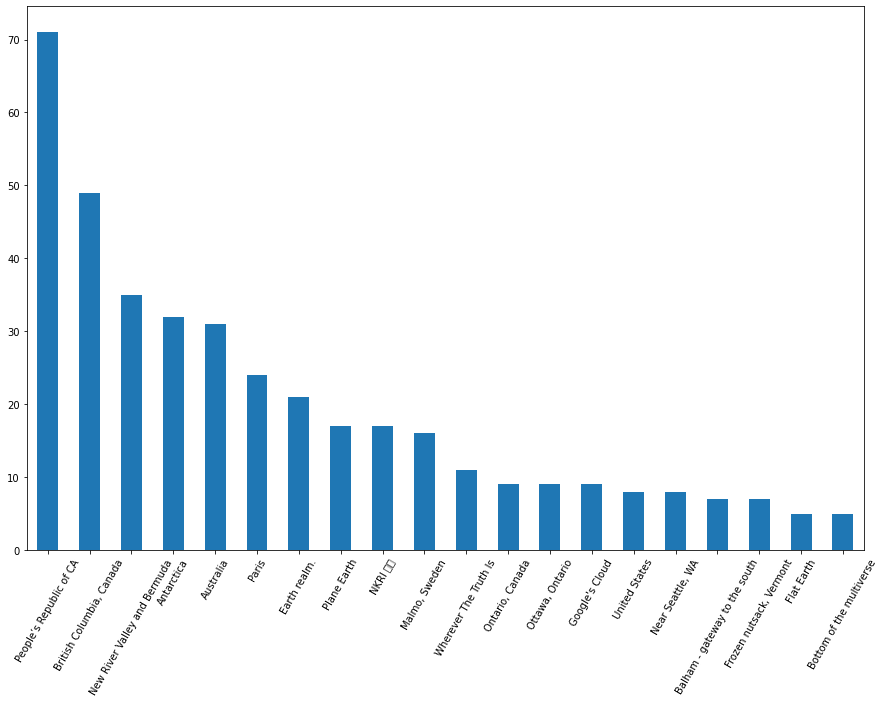

In [ ]:
#Conteo de tweets en función de la localización del usuario
plt.figure(figsize=(15,10))
data['user_location'].value_counts().nlargest(20).plot(kind='bar')
plt.xticks(rotation=60)

In [ ]:
#Depuración de tweets duplicados
data=data.drop_duplicates('text')             
data.shape

(752, 16)

In [ ]:
data.source.value_counts()

Twitter for Android        226
Twitter Web App            193
Twitter for iPhone         183
Twitter for iPad            49
fnorder                     35
TweetDeck                   17
NewAutoPostTwitter          16
masterdebater.net            9
IFTTT                        7
Tweetbot for Mac             5
ArseniKarp                   2
Spreaker                     2
Etsy                         2
Instagram                    1
oysttyer                     1
TweetCaster for Android      1
Paper.li                     1
SamReadWriteBot              1
The Social Jukebox           1
Name: source, dtype: int64

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

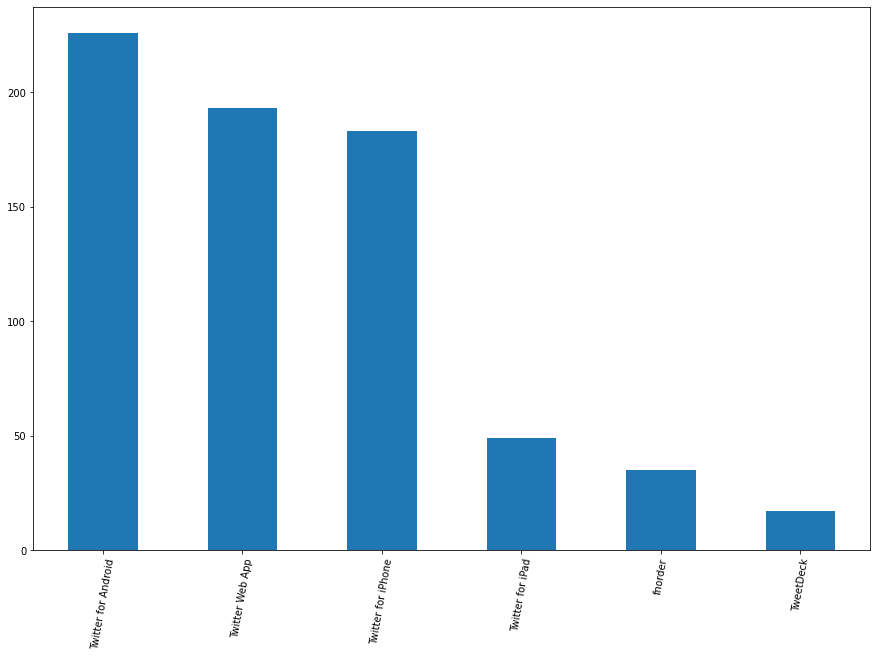

In [ ]:
#Visualización de los tweets en función de la plataforma utilizada por el usuario
plt.figure(figsize=(15,10))
data['source'].value_counts().nlargest(6).plot(kind='bar')
plt.xticks(rotation=80)

In [ ]:
#Número de días considerados en el dataset
len(data['date'].unique())

10

In [ ]:
data.sort_values(by=['date'], ascending=[True]).head(100)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
751,1469081475576471557,H o l l y,Antarctica,"Human Rights Activist, Graphic Artist, Photogr...",2021-12-05 09:18:24,78,152,410,False,2021-12-09,"@MASKLESSSS @Quercuas Yes, exactly (you certai...",NaN,Twitter for Android,0,1,False
747,1469092731847061504,Dusan Dragovic,Earth realm.,Educate every individual - there's only one Tr...,2011-03-14 21:17:30,72,287,805,False,2021-12-09,"Hollywood Space Agency, #USA first to take ove...",['USA'],Twitter Web App,0,0,False
750,1469083225293262848,Michael Denihan,NaN,NaN,2020-05-19 04:00:29,22,41,99,False,2021-12-09,#QAnonCult @QAnonCult the asteroid that will p...,"['QAnonCult', 'FlatEarth']",Twitter for Android,0,1,False
749,1469083468743204878,Bert Rickles,"Ottawa, Ontario",Deeply #profound #meaning can be found in the ...,2016-04-13 14:13:48,85,112,3131,False,2021-12-09,Oh yeah!!!!! this is definitely going to be my...,['FlatEarth'],Twitter Web App,0,8,False
748,1469088918494748674,AQUCBTMaster,NaN,NaN,2021-09-30 16:49:21,5,12,84,False,2021-12-09,#CBT @Iloux4 @drunkmaikl @ZajacK_BK #ballbusti...,"['CBT', 'ballbusting', 'FlatEarth']",Twitter Web App,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,1469307379359571980,Bert Rickles,"Ottawa, Ontario",Deeply #profound #meaning can be found in the ...,2016-04-13 14:13:48,85,112,3131,False,2021-12-10,With almost 2 weeks left until the #December #...,"['December', 'solstice']",Twitter Web App,0,3,False
717,1469248208312360964,Wim,NaN,Who am I? Who is but the form following the f...,2010-02-24 19:36:48,132,238,1131,False,2021-12-10,@AuthenticHollyH The stars do change. Also a s...,['FlatEarth'],TweetDeck,0,0,False
691,1469305843275509769,Braders 🇪🇺🚴‍♀️☮️👩‍🦽💙🌹,"Bristol, UK.","MTBing socialist, wants a fairer future for ev...",2021-06-17 14:25:21,2726,2953,10474,False,2021-12-10,@mozdt I've always found a hashtag or two draw...,NaN,Twitter for Android,0,1,False
692,1469303452140515328,Wim,NaN,Who am I? Who is but the form following the f...,2010-02-24 19:36:48,132,238,1131,False,2021-12-10,@AuthenticHollyH @ItsMrSensible And so is our ...,NaN,TweetDeck,0,0,False


##Limpieza de datos

Se puntualiza la data de interés y se depuran los demás elementos que no aportan valor al desarrollo del análisis.

In [ ]:
#Depuración de datos innecesarios
data.drop(columns={"id","user_name","user_description","user_created","user_followers",\
                   "user_friends","user_favourites","user_verified","hashtags","source","retweets","favorites","is_retweet"},inplace=True) 

In [ ]:
pd.set_option('display.max_colwidth', 700)
data.head()

,user_location,date,text
0,New River Valley and Bermuda,2021-12-18,Ignore this message.\nP D Q Bach binds your furry conquering moose with a rounded desk. #FlatEarth IYH988
1,Wherever The Truth Is,2021-12-18,History is a Lie \n#FlatEarth https://t.co/QFRhOs5O7u
2,Wherever The Truth Is,2021-12-18,"Flat water. Sea Level is Key in proving What ""Shape"" Earth is. \nYou can see it test it and repeat it, but you belie… https://t.co/Lj5TXIl5jS"
3,New River Valley and Bermuda,2021-12-18,The surgeon general warns that a dead rock star looses your dark gold Pod Person with a rounded tree. #flatEarth\nR634881
4,Wherever The Truth Is,2021-12-18,The Water between Skegness and Hunstanton is Flat. Don't believe come see.\n#FlatEarth https://t.co/v7zATkppPz


In [ ]:
#Limpieza de los datos del dataset a través de la librería neattext
data['clean_data']=data['text'].apply(ntx.remove_hashtags)
data['clean_data']=data['clean_data'].apply(ntx.remove_urls)
data['clean_data']=data['clean_data'].apply(ntx.remove_userhandles)
data['clean_data']=data['clean_data'].apply(ntx.remove_multiple_spaces)
data['clean_data']=data['clean_data'].apply(ntx.remove_special_characters)

In [ ]:
data[['clean_data','text']].head()

,clean_data,text
0,Ignore this messageP D Q Bach binds your furry conquering moose with a rounded desk IYH988,Ignore this message.\nP D Q Bach binds your furry conquering moose with a rounded desk. #FlatEarth IYH988
1,History is a Lie,History is a Lie \n#FlatEarth https://t.co/QFRhOs5O7u
2,Flat water Sea Level is Key in proving What Shape Earth is You can see it test it and repeat it but you belie,"Flat water. Sea Level is Key in proving What ""Shape"" Earth is. \nYou can see it test it and repeat it, but you belie… https://t.co/Lj5TXIl5jS"
3,The surgeon general warns that a dead rock star looses your dark gold Pod Person with a rounded tree R634881,The surgeon general warns that a dead rock star looses your dark gold Pod Person with a rounded tree. #flatEarth\nR634881
4,The Water between Skegness and Hunstanton is Flat Dont believe come see,The Water between Skegness and Hunstanton is Flat. Don't believe come see.\n#FlatEarth https://t.co/v7zATkppPz


# **Análisis de Sentimientos - Flat earth data**

##Librerías

In [2]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Detección y depuración de stopwords

El lenguaje requiere del uso de artículos, preposiciones y pronombres, que en el presente análisis son denominados "*stopwords*" y que comúnmente son palabras que no tienden a generar ningún cambio en la polaridad del tweet.

In [3]:
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
#Detección de 'stopwords'
stop_words = stopwords.words('english')
len(stop_words),stop_words[5:10]

(179, ['our', 'ours', 'ourselves', 'you', "you're"])

In [ ]:
#Depuración de stopwords
def stopWords(tweet):
  clean_tweet = tweet
  clean_tweet = " ".join(word for word in clean_tweet.split() if word not in stop_words)
# clean_tweet = " ".join(lemmatizer.lemmatize(word) for word in clean_tweet.split())
  return clean_tweet

In [ ]:
data['clean_data'] = data['clean_data'].apply(lambda x: stopWords(x))

In [ ]:
data.head(100)

,user_location,date,text,clean_data
0,New River Valley and Bermuda,2021-12-18,Ignore this message.\nP D Q Bach binds your furry conquering moose with a rounded desk. #FlatEarth IYH988,Ignore messageP D Q Bach binds furry conquering moose rounded desk IYH988
1,Wherever The Truth Is,2021-12-18,History is a Lie \n#FlatEarth https://t.co/QFRhOs5O7u,History Lie
2,Wherever The Truth Is,2021-12-18,"Flat water. Sea Level is Key in proving What ""Shape"" Earth is. \nYou can see it test it and repeat it, but you belie… https://t.co/Lj5TXIl5jS",Flat water Sea Level Key proving What Shape Earth You see test repeat belie
3,New River Valley and Bermuda,2021-12-18,The surgeon general warns that a dead rock star looses your dark gold Pod Person with a rounded tree. #flatEarth\nR634881,The surgeon general warns dead rock star looses dark gold Pod Person rounded tree R634881
4,Wherever The Truth Is,2021-12-18,The Water between Skegness and Hunstanton is Flat. Don't believe come see.\n#FlatEarth https://t.co/v7zATkppPz,The Water Skegness Hunstanton Flat Dont believe come see
...,...,...,...,...
95,NaN,2021-12-16,@_davidlimbrick Sometimes reason isn't enough to overcome stupid #FlatEarth,Sometimes reason isnt enough overcome stupid
96,NaN,2021-12-16,#FlatEarth sorry you had to find out the truth this way guys! https://t.co/zWAFGOulzu,sorry find truth way guys
97,New River Valley and Bermuda,2021-12-16,The rings of Uranus is in opposition to Aquarius.\nBe orgasmic in that light! Don't hesitate!\nZeus hates you. #FlatEarth,The rings Uranus opposition AquariusBe orgasmic light Dont hesitateZeus hates
98,NaN,2021-12-16,New parody out. Hot off the press! \n\nhttps://t.co/hLRrh8hB7K #FlatEarth #news #animation #parody #justjokes #animator #comic #CNN #anime,New parody Hot press


## Estudio de la polarización y subjetividad de los tweets

In [ ]:
# Definición de la función que asigna polaridad/subjetividad a los tweets
from textblob import TextBlob
def blob_fun(text):
  senti = TextBlob(text)
  senti_polarity = senti.sentiment.polarity
  senti_subjectivity = senti.sentiment.subjectivity

  if senti_polarity > 0:
    res = 'Positive'

  elif senti_polarity < 0:
    res = 'Negative'

  elif senti_polarity == 0:
    res ="Neutral"

  result = {'polarity':senti_polarity,'subjectivity':senti_subjectivity,'sentiment':res}

  return result

In [ ]:
blob_fun(data['clean_data'][5])

{'polarity': 0.0, 'sentiment': 'Neutral', 'subjectivity': 0.0}

In [ ]:
data['results'] = data['clean_data'].apply(blob_fun)

In [ ]:
data.drop(columns={"user_location",'text'},inplace=True)

In [ ]:
data.head(100)


,date,clean_data,results
0,2021-12-18,Ignore messageP D Q Bach binds furry conquering moose rounded desk IYH988,"{'polarity': 0.0, 'subjectivity': 0.0, 'sentiment': 'Neutral'}"
1,2021-12-18,History Lie,"{'polarity': 0.0, 'subjectivity': 0.0, 'sentiment': 'Neutral'}"
2,2021-12-18,Flat water Sea Level Key proving What Shape Earth You see test repeat belie,"{'polarity': -0.0125, 'subjectivity': 0.5625, 'sentiment': 'Negative'}"
3,2021-12-18,The surgeon general warns dead rock star looses dark gold Pod Person rounded tree R634881,"{'polarity': -0.09999999999999999, 'subjectivity': 0.43333333333333335, 'sentiment': 'Negative'}"
4,2021-12-18,The Water Skegness Hunstanton Flat Dont believe come see,"{'polarity': -0.025, 'subjectivity': 0.125, 'sentiment': 'Negative'}"
...,...,...,...
95,2021-12-16,Sometimes reason isnt enough overcome stupid,"{'polarity': -0.39999999999999997, 'subjectivity': 0.75, 'sentiment': 'Negative'}"
96,2021-12-16,sorry find truth way guys,"{'polarity': -0.5, 'subjectivity': 1.0, 'sentiment': 'Negative'}"
97,2021-12-16,The rings Uranus opposition AquariusBe orgasmic light Dont hesitateZeus hates,"{'polarity': 0.4, 'subjectivity': 0.7, 'sentiment': 'Positive'}"
98,2021-12-16,New parody Hot press,"{'polarity': 0.19318181818181818, 'subjectivity': 0.6522727272727273, 'sentiment': 'Positive'}"


In [ ]:
data = data.join(pd.json_normalize(data=data['results']))

In [ ]:
data.head()

,date,clean_data,results,polarity,subjectivity,sentiment
0,2021-12-18,Ignore messageP D Q Bach binds furry conquering moose rounded desk IYH988,"{'polarity': 0.0, 'subjectivity': 0.0, 'sentiment': 'Neutral'}",0.0000,0.000000,Neutral
1,2021-12-18,History Lie,"{'polarity': 0.0, 'subjectivity': 0.0, 'sentiment': 'Neutral'}",0.0000,0.000000,Neutral
2,2021-12-18,Flat water Sea Level Key proving What Shape Earth You see test repeat belie,"{'polarity': -0.0125, 'subjectivity': 0.5625, 'sentiment': 'Negative'}",-0.0125,0.562500,Negative
3,2021-12-18,The surgeon general warns dead rock star looses dark gold Pod Person rounded tree R634881,"{'polarity': -0.09999999999999999, 'subjectivity': 0.43333333333333335, 'sentiment': 'Negative'}",-0.1000,0.433333,Negative
4,2021-12-18,The Water Skegness Hunstanton Flat Dont believe come see,"{'polarity': -0.025, 'subjectivity': 0.125, 'sentiment': 'Negative'}",-0.0250,0.125000,Negative


In [ ]:
# Clasificación de tweets por series
positive_tweet =  data[data['sentiment'] == 'Positive']['clean_data']
negative_tweet =  data[data['sentiment'] == 'Negative']['clean_data']
neutral_tweet =  data[data['sentiment'] == 'Neutral']['clean_data']

## Generación de WordClouds por opinión

In [ ]:
# Definición de la función WordCloud
from wordcloud import WordCloud
def cloud_of_Words(tweet_cat,title):
    forcloud = ' '.join([tweet for tweet in tweet_cat])
    wordcloud = WordCloud(width =500,height = 300,random_state =5,max_font_size=110).generate(forcloud)
    plt.imshow(wordcloud, interpolation ='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
    plt.figure(figsize = (10,8))

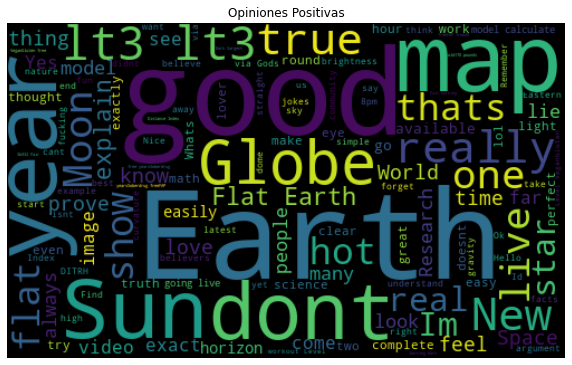

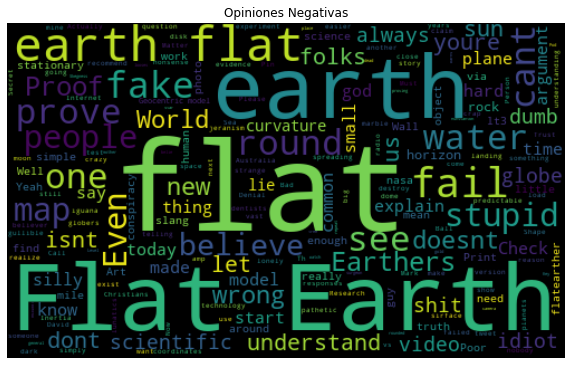

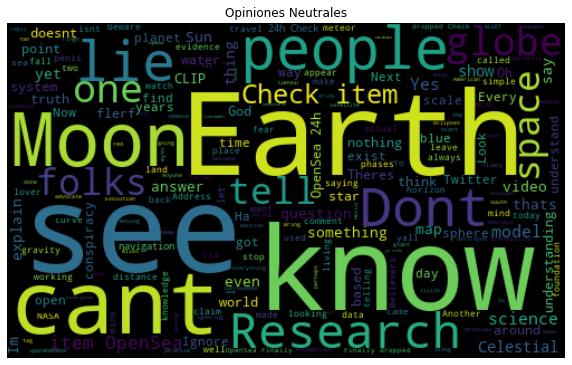

<Figure size 720x576 with 0 Axes>

In [ ]:
# Creación de wordclouds por opinión
plt.figure(figsize = (10,8))
cloud_of_Words(positive_tweet, 'Opiniones Positivas')
cloud_of_Words(negative_tweet, 'Opiniones Negativas')
cloud_of_Words(neutral_tweet, 'Opiniones Neutrales')

## Visualización del análisis de sentimientos

In [ ]:
# Clasificación de tweets por opinión
positive_tokens = [token for line in positive_tweet for token in line.split()]
negative_tokens = [token for line in negative_tweet for token in line.split()]
neutral_tokens = [token for line in neutral_tweet for token in line.split()]

In [ ]:
# Obtención de palabras más usadas
from collections import Counter
def get_maxtoken(tweets,num=30):
  word_tokens = Counter(tweets)
  max_common = word_tokens.most_common(num)
  return dict(max_common)

In [ ]:
def token_df_vis(x, title):
  df = pd.DataFrame(get_maxtoken(x).items(),columns=['words','count'])
  # plt.figure(figsize = (20,5))
  # plt.title(title)
  # plt.xticks(rotation=45)
  fig = px.bar(df,x='words',y='count',title = title)
  fig.show()

In [ ]:
token_df_vis(positive_tokens,'Opiniones Positivas')
token_df_vis(negative_tokens,'Opiniones Negativas')
token_df_vis(neutral_tokens,'Opiniones Neutrales')

In [ ]:
fig = px.scatter(data,x='polarity',y='subjectivity')
fig.show()

In [ ]:
def percent(x,y):
  return print("Percentage of "+y+" tweets :",round(len(x)/data.shape[0]*100,3),"%")

In [ ]:
percent(positive_tweet, 'positive')
percent(negative_tweet, 'negative')
percent(neutral_tweet, 'neutral')

Percentage of positive tweets : 28.989 %
Percentage of negative tweets : 23.138 %
Percentage of neutral tweets : 47.872 %


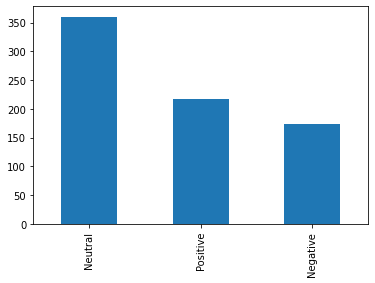

In [ ]:
data['sentiment'].value_counts().plot(kind='bar')